In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as  plt
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.utils import Sequence
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, TimeDistributed, LSTM
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD
from collections import Counter

In [3]:
image_size = (128, 128)
sequence_length = 5

model = Sequential([
    TimeDistributed(Conv2D(8, (3,3), activation='relu', padding='same'), input_shape=(sequence_length, image_size[0], image_size[1], 3)),
    TimeDistributed(BatchNormalization()),  
    TimeDistributed(MaxPooling2D(pool_size=(2,2))),

    TimeDistributed(Conv2D(16, (3,3), activation='relu', padding='same')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(pool_size=(2,2))),

    TimeDistributed(Conv2D(32, (3,3), activation='relu', padding='same')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(pool_size=(2,2))),

    TimeDistributed(GlobalAveragePooling2D()),  
    LSTM(16, return_sequences=False),  
    Dropout(0.3),

    Dense(8, activation='relu'),  
    Dropout(0.3),
    Dense(1, activation='sigmoid')  
])  

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

/Users/xiaobin/Desktop/2025/566/final_project/drowness_detection/.venv/lib/python3.10/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 5, 128, 128, 8) │           224 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 5, 128, 128, 8) │            32 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 5, 64, 64, 8)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 5, 64, 64, 16)  │         1,168 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 5, 64, 64, 16)  │            64 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 5, 32, 32, 16)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 5, 32, 32, 32)  │         4,640 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 5, 32, 32, 32)  │           128 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, 5, 16, 16, 32)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_9              │ (None, 5, 32)          │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,537 (37.25 KB)

 Trainable params: 9,425 (36.82 KB)

 Non-trainable params: 112 (448.00 B)

In [4]:
import os, cv2, numpy as np, random
import re
from tensorflow.keras.utils import Sequence


class VideoSequenceGenerator(Sequence):
    def __init__(self, base_path, classes, seq_len, batch_size=4, shuffle=True, img_size=(128,128)):
        self.seq_len = seq_len
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.img_size = img_size
        self.samples = []  # list of (frame_path_list, label)

        for label, cls in enumerate(classes):
            class_dir = os.path.join(base_path, cls)

            all_frames = sorted([f for f in os.listdir(class_dir) if f.endswith(".png")])

            # ---- Group by prefix (video ID) ----
            videos = {}
            for f in all_frames:
                prefix = re.match(r'[A-Za-z]+', f).group()
                videos.setdefault(prefix, []).append(f)

            # ---- Build sequences for each video ----
            for prefix, frames in videos.items():
                if len(frames) < seq_len:
                    continue

                for i in range(len(frames) - seq_len + 1):
                    frame_paths = [
                        os.path.join(class_dir, frames[i+j])
                        for j in range(seq_len)
                    ]
                    self.samples.append((frame_paths, label))

        if shuffle:
            random.shuffle(self.samples)

    def __len__(self):
        return len(self.samples) // self.batch_size

    def __getitem__(self, index):
        batch = self.samples[index*self.batch_size:(index+1)*self.batch_size]
        X, y = [], []

        for frame_paths, label in batch:
            seq = [cv2.imread(fp) for fp in frame_paths]
            seq = [cv2.resize(im, self.img_size) / 255.0 for im in seq]
            X.append(seq)
            y.append(label)

        return np.array(X), np.array(y)


In [9]:
import random
base_path = "../data/splitted_Data"
classes = ["Drowsy", "Non Drowsy"]
seq_len = 10
batch_size = 4

train_path = os.path.join(base_path, "train")
val_path = os.path.join(base_path, "test")
print("Train path:", train_path)


train_gen = VideoSequenceGenerator(train_path, classes, seq_len, batch_size=batch_size)
val_gen   = VideoSequenceGenerator(val_path, classes, seq_len, batch_size=batch_size)

print("Train sequences:", len(train_gen))
print("Val sequences:", len(val_gen))

Train path: ../data/splitted_Data/train
Train sequences: 8237
Val sequences: 405


Sample label: Drowsy
Frame paths (to verify ordering):
  U0138.png
  U0140.png
  U0141.png
  U0142.png
  U0144.png
  U0146.png
  U0147.png
  U0149.png
  U0151.png
  U0152.png


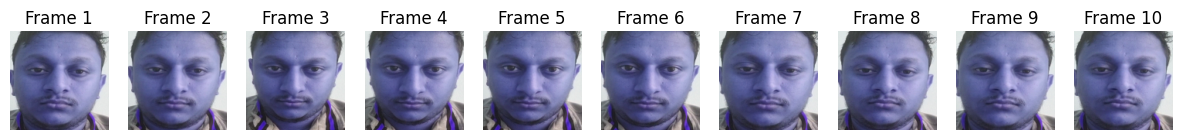

In [15]:
import matplotlib.pyplot as plt
import random

 
X_batch, y_batch = train_gen[random.randint(0, len(train_gen)-1)]

 
idx = random.randint(0, len(X_batch)-1)
frames = X_batch[idx]
label = y_batch[idx]

 
frame_paths, _ = train_gen.samples[
    random.randint(0, len(train_gen.samples)-1)
]

print("Sample label:", "Drowsy" if label == 1 else "Awake")
print("Frame paths (to verify ordering):")
for fp in frame_paths:
    print(" ", fp.split("/")[-1])  # 

 
plt.figure(figsize=(15, 3))
for i in range(len(frames)):
    plt.subplot(1, len(frames), i+1)
    plt.imshow(frames[i])
    plt.title(f"Frame {i+1}")
    plt.axis('off')

plt.show()


In [14]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20
)

Epoch 1/20


/Users/xiaobin/Desktop/2025/566/final_project/drowness_detection/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8304/8304 ━━━━━━━━━━━━━━━━━━━━ 403s 48ms/step - accuracy: 0.7465 - loss: 0.4992 - val_accuracy: 0.9781 - val_loss: 0.1243
Epoch 2/20
8304/8304 ━━━━━━━━━━━━━━━━━━━━ 413s 50ms/step - accuracy: 0.9288 - loss: 0.2081 - val_accuracy: 0.9931 - val_loss: 0.0313
Epoch 3/20
8304/8304 ━━━━━━━━━━━━━━━━━━━━ 405s 49ms/step - accuracy: 0.9652 - loss: 0.1144 - val_accuracy: 0.9979 - val_loss: 0.0092
Epoch 4/20
8304/8304 ━━━━━━━━━━━━━━━━━━━━ 396s 48ms/step - accuracy: 0.9755 - loss: 0.0805 - val_accuracy: 0.9973 - val_loss: 0.0050
Epoch 5/20
8304/8304 ━━━━━━━━━━━━━━━━━━━━ 386s 46ms/step - accuracy: 0.9787 - loss: 0.0676 - val_accuracy: 0.9989 - val_loss: 0.0072
Epoch 6/20
8304/8304 ━━━━━━━━━━━━━━━━━━━━ 384s 46ms/step - accuracy: 0.9823 - loss: 0.0557 - val_accuracy: 1.0000 - val_loss: 0.0012
Epoch 7/20
8304/8304 ━━━━━━━━━━━━━━━━━━━━ 388s 47ms/step - accuracy: 0.9834 - loss: 0.0505 - val_accuracy: 1.0000 - val_loss: 2.6710e-04
Epoch 8/20
8304/8304 ━━━━━━━━━━━━━━━━━━━━ 385s 46ms/step - accuracy: 0.9881 

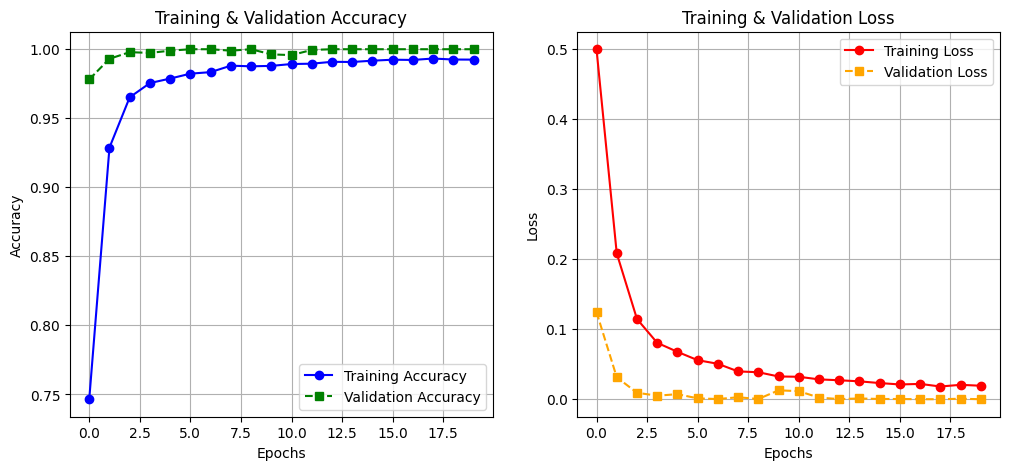

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy", color="blue", marker="o", linestyle="-")
plt.plot(epochs_range, val_acc, label="Validation Accuracy", color="green", marker="s", linestyle="--")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss", color="red", marker="o", linestyle="-")
plt.plot(epochs_range, val_loss, label="Validation Loss", color="orange", marker="s", linestyle="--")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.grid(True)

plt.show()

In [ ]:
 
classes = ["Drowsy", "Non Drowsy"]  

seq_len = 5
batch_size = 32  

test_path = os.path.join(base_path, "test")

test_gen = VideoSequenceGenerator(
    test_path,
    classes,
    seq_len,
    batch_size=batch_size,
    shuffle=False   
)

print("Test samples:", len(test_gen))

# Evaluate the model on test data
print("Evaluating model on test data...")
test_loss, test_accuracy = model.evaluate(test_gen, verbose=1)
print(f"\nTest Results:")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")


Test samples: 58
Evaluating model on test data...


/Users/xiaobin/Desktop/2025/566/final_project/drowness_detection/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 177ms/step - accuracy: 1.0000 - loss: 1.7632e-05

Test Results:
Test Accuracy: 1.0000
Test Loss: 0.0000


In [17]:
print("Generating predictions for detailed evaluation...")
y_true = []
y_pred = []

# Collect all test predictions
for i in range(len(test_gen)):
    X_batch, y_batch = test_gen[i]
    predictions = model.predict(X_batch, verbose=0)
    
    # Convert predictions to binary (0 or 1)
    pred_binary = (predictions > 0.5).astype(int).flatten()
    
    y_true.extend(y_batch)
    y_pred.extend(pred_binary)

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

print(f"Total test samples: {len(y_true)}")
print("Predictions generated successfully!")

Generating predictions for detailed evaluation...
Total test samples: 1856
Predictions generated successfully!


In [20]:
print("Classification Report:")
print("="*50)
print(classification_report(y_true, y_pred, target_names=['Awake', 'Drowsy']))

# Calculate additional metrics
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"\nDetailed Metrics:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Classification Report:
              precision    recall  f1-score   support

       Awake       1.00      1.00      1.00      1006
      Drowsy       1.00      1.00      1.00       850

    accuracy                           1.00      1856
   macro avg       1.00      1.00      1.00      1856
weighted avg       1.00      1.00      1.00      1856


Detailed Metrics:
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000


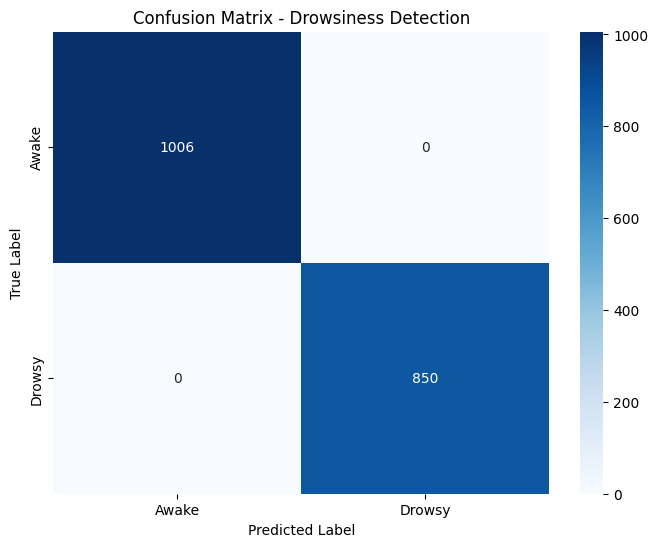

Confusion Matrix Values:
True Negatives (Correctly predicted Awake): 1006
False Positives (Incorrectly predicted Drowsy): 0
False Negatives (Incorrectly predicted Awake): 0
True Positives (Correctly predicted Drowsy): 850


In [21]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Awake', 'Drowsy'], 
            yticklabels=['Awake', 'Drowsy'])
plt.title('Confusion Matrix - Drowsiness Detection')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Print confusion matrix values
print("Confusion Matrix Values:")
print(f"True Negatives (Correctly predicted Awake): {cm[0,0]}")
print(f"False Positives (Incorrectly predicted Drowsy): {cm[0,1]}")
print(f"False Negatives (Incorrectly predicted Awake): {cm[1,0]}")
print(f"True Positives (Correctly predicted Drowsy): {cm[1,1]}")

In [22]:
import pickle
try:
    with open('./kaggle/working/drowsiness_lstm_model.pkl', 'wb') as f:
        pickle.dump(model, f)
    print("✓ Model saved as .pkl file")
except Exception as e:
    print(f"⚠ Pickle saving failed: {e}")
    print("Use .h5 or SavedModel format instead")

✓ Model saved as .pkl file
